In [17]:
import warnings
import pandas as pd
import os
import statsmodels.formula.api as smf

from causallearn.search.ConstraintBased.PC import pc
from dowhy import CausalModel

warnings.filterwarnings('ignore')

### Read the observational data

In [18]:
path = os.getcwd()
file_path = path + '\\data\social_media_engagement_data.csv'
data_sme = pd.read_csv(file_path, header=0,sep=';')
data_sme.head()

,Platform,Post ID,Post Type,Post Content,Post Timestamp,Date,Weekday Type,Time,Time Periods,Likes,...,Engagement Rate,Audience Age,Age Group,Audience Gender,Audience Location,Audience Continent,Audience Interests,Campaign ID,Sentiment,Influencer ID
0,Instagram,16ce29c5-2dc7-478f-9814-a86754f3ce8b,Video,Increase fast partner south.,30.07.2023 06:40,7.30.2023 (Sonntag),Weekend,6:40:06,Morning,908,...,"91,41",48,Senior Adults,Male,Greece,Europe,population,NaN,Neutral,NaN
1,Facebook,a30c948b-0fb3-4e92-95da-e2dea184f568,Link,Floor glass bring indicate seem detail.,19.06.2022 14:16,6.19.2022 (Sonntag),Weekend,14:16:00,Afternoon,604,...,"45,82",33,Mature Adults,Female,Lao People's Democratic Republic,Asia,attorney,98705a1e-2573-4cb8-983b-2112d4b140c9,Mixed,NaN
2,Twitter,aee74d06-c775-459c-8fc4-013ce25644f1,Image,Customer stop language everybody rest chance me.,04.06.2022 06:19,6.4.2022 (Samstag),Weekend,6:19:50,Morning,288,...,"22,81",23,Adolescent Adults,Other,Jordan,Asia,affect,NaN,Positive,NaN
3,Instagram,80415748-a509-4fc6-8b55-74f2babe5dac,Image,Town find identify game your.,12.05.2022 15:41,5.12.2022 (Donnerstag),Weekday,15:41:22,Afternoon,870,...,"70,95",48,Senior Adults,Male,Sudan,Africa,money,6b15bf9b-14cc-4ab9-9168-56322057b61e,Positive,NaN
4,LinkedIn,14d34185-639a-4508-a8b6-02a743fe0dbc,Link,Seem strategy you cup.,26.10.2023 20:53,10.26.2023 (Donnerstag),Weekday,20:53:33,Evening,573,...,"40,23",40,Mature Adults,Male,Gabon,Africa,part,NaN,Negative,NaN


### I am only interested in the local causal graph that includes the variables
- Likes: The number of likes received on the post.
- Comments: The number of comments received on the post.
- Shares: The number of shares the post received.
- Reach: The number of unique users who saw the post.
- Engagement Rate: The rate of engagement on the post, typically calculated as the sum of likes, comments, and shares divided by the total reach.
- Impressions: The total number of times the post was displayed to users.

In [19]:
df = data_sme[['Engagement Rate', 'Likes', 'Comments', 'Shares', 'Impressions', 'Reach']]
df['Engagement Rate'] = df['Engagement Rate'].str.replace(',', '.').astype(float)

df.head()

,Engagement Rate,Likes,Comments,Shares,Impressions,Reach
0,91.41,908,125,85,3884,1223
1,45.82,604,29,2,1831,1386
2,22.81,288,230,56,3927,2516
3,70.95,870,92,15,4829,1377
4,40.23,573,192,19,2797,1949


### Create a Causal Graph of the included variables using the PC Algorithm

  0%|          | 0/6 [00:00<?, ?it/s]

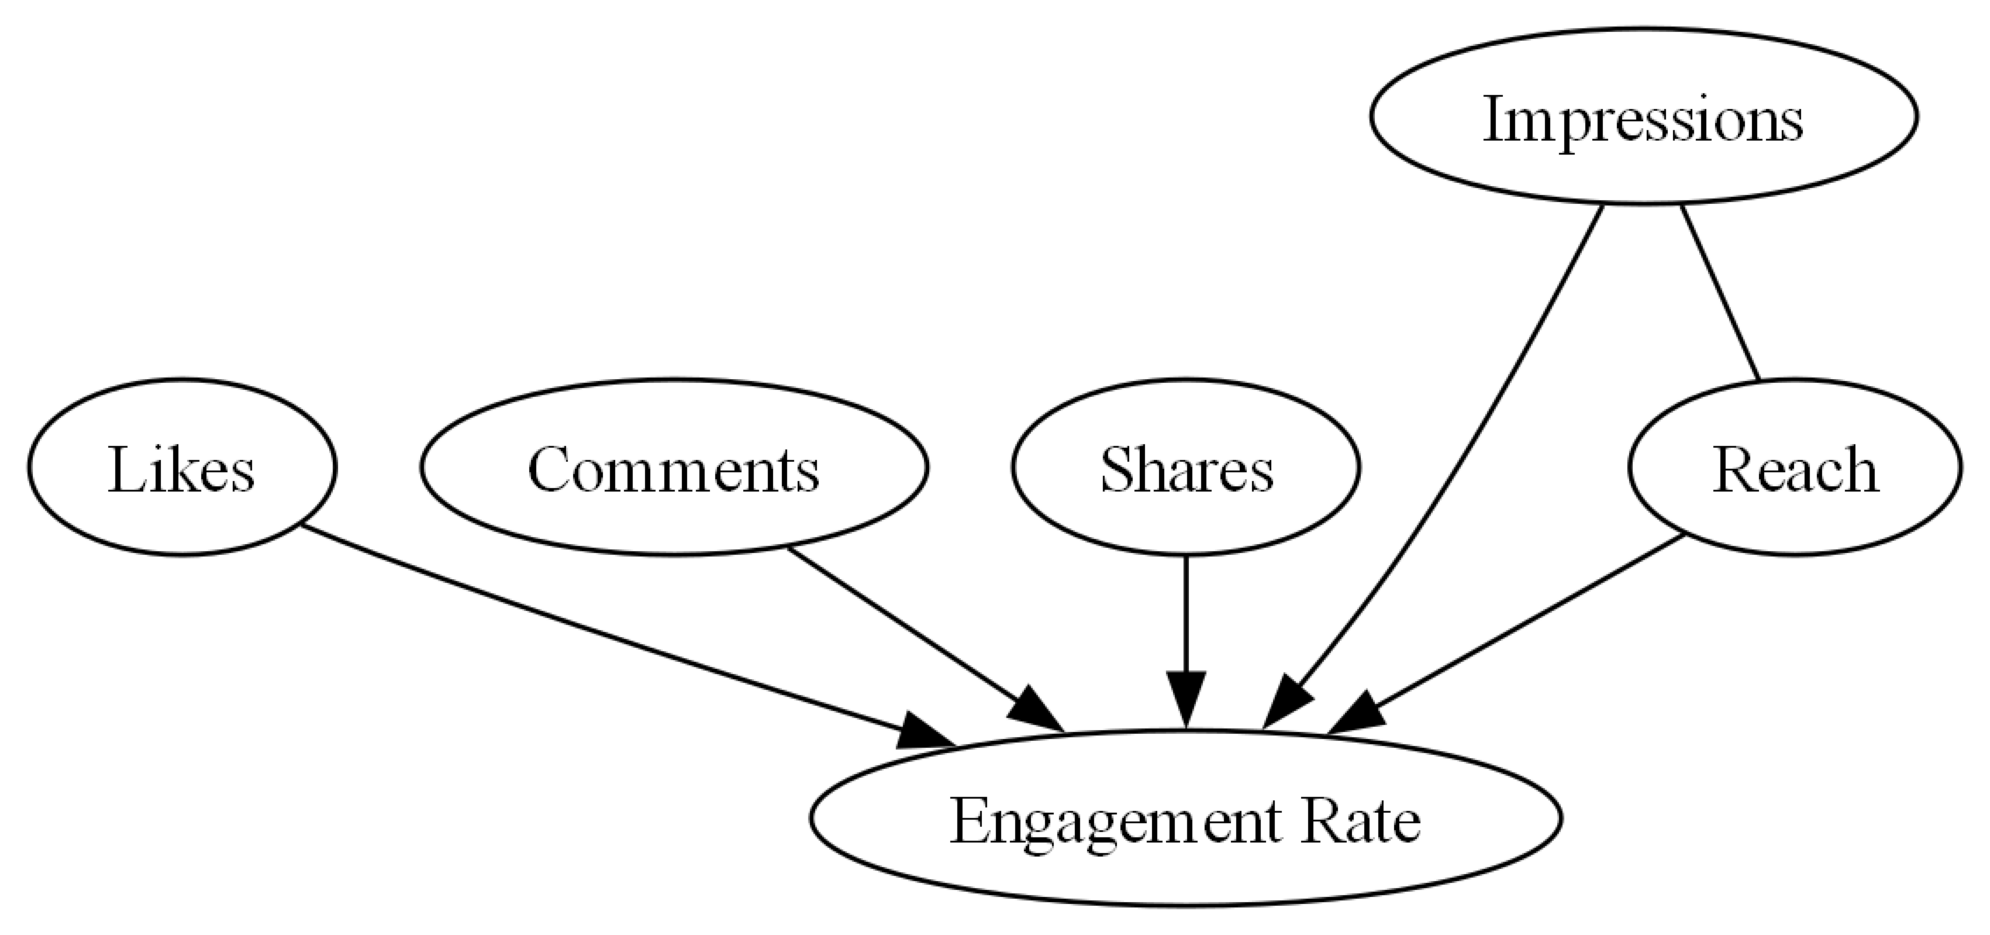

In [20]:
# AUTOMATICALLY ESTIMATED GRAPH FROM DATA!
labels = [f'{col}' for i, col in enumerate(df.columns)]
data = df.to_numpy()

# Alpha level is 0.05 since I am interested in a causal representation as close as possible to the truth
# A p-value of 0.05 indicates that we cannot reject the null hypothesis that the causal relationship depicted in the graph is correct
cg = pc(data, alpha=0.05)
cg.draw_pydot_graph(labels=labels)

### I make a reasonable assumption that an increase in the reach of the post lead to more impressions
### i.e. Reach has a causal relationship to Impressions

In [21]:
treatment = 'Reach'
outcome = 'Impressions'

reg_model = smf.ols(formula=f"Q('{outcome}') ~ Q('{treatment}')", data = df)
ols = reg_model.fit()
reg_coeff = ols.params[f"Q('{treatment}')"]
print(f'Regression Coefficient of Reach: {reg_coeff}')

Regression Coefficient of Reach: 0.5305184761644058


### I would like to know whether an increase in Impressions create more Engagement?

In [22]:
treatment = 'Impressions'
outcome = 'Engagement Rate'
common_cause = 'Reach'

### Define a causal model for Impressions and Engagement Rate

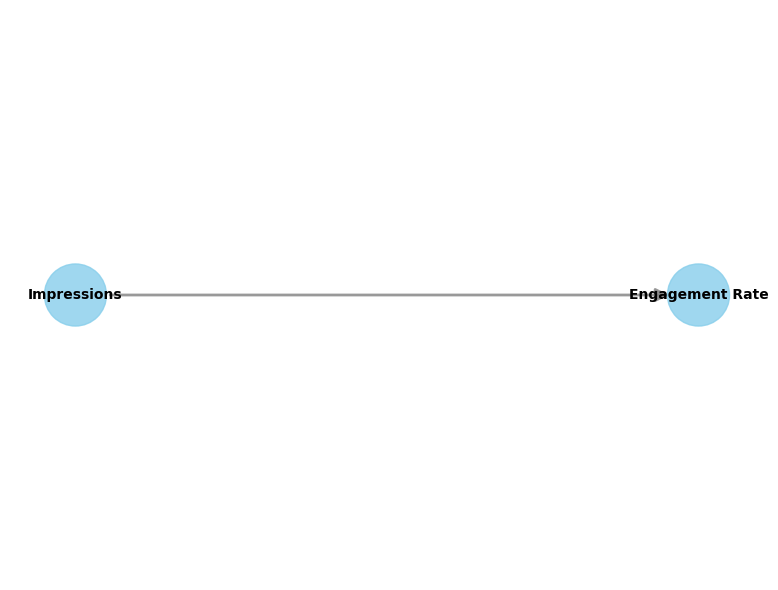

In [23]:
# Create a causal model of Impressions and Engagement Rate
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
)

# View causal graph
model.view_model()

In [24]:
# Identify causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [25]:
# Estimate causal effect using linear regression
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 effect_modifiers= [],
                                 confidence_intervals=True,
                                 test_significance=True)

# Print results
print(estimate)
estimate.interpret()

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                           
──────────────(E[Engagement Rate])
d[Impressions]                    
Estimand assumption 1, Unconfoundedness: If U→{Impressions} and U→Engagement Rate then P(Engagement Rate|Impressions,,U) = P(Engagement Rate|Impressions,)

## Realized estimand
b: Engagement Rate~Impressions
Target units: ate

## Estimate
Mean value: -0.0023848214978059445
p-value: [0.]
95.0% confidence interval: [[-0.00248535 -0.00228429]]

Increasing the treatment variable(s) [Impressions] from 0 to 1 causes an increase of -0.0023848214978059445 in the expected value of the outcome [['Engagement Rate']], over the data distribution/population represented by the dataset.


### Result is interesting. An increase in Impressions lead to less Engagement

### Define a causal model of Impressions and Engagement Rate with a common cause Reach

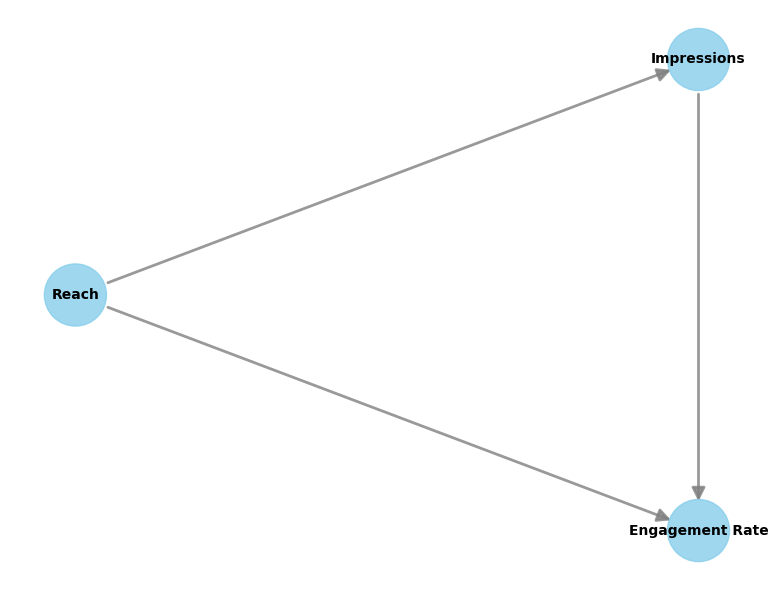

In [26]:
# Create a causal model of Impressions and Engagement Rate and a common cause Reach
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=[common_cause]
)

# View causal graph
model.view_model()

In [27]:
# Identify causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [28]:
# Estimate causal effect using linear regression
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 effect_modifiers= [],
                                 confidence_intervals=True,
                                 test_significance=True)

# Print results
print(estimate)
estimate.interpret()

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                 
──────────────(E[Engagement Rate|Reach])
d[Impressions]                          
Estimand assumption 1, Unconfoundedness: If U→{Impressions} and U→Engagement Rate then P(Engagement Rate|Impressions,Reach,U) = P(Engagement Rate|Impressions,Reach)

## Realized estimand
b: Engagement Rate~Impressions+Reach
Target units: ate

## Estimate
Mean value: 0.0008328964000838823
p-value: [3.95219572e-100]
95.0% confidence interval: [[0.00075613 0.00090966]]

Increasing the treatment variable(s) [Impressions] from 0 to 1 causes an increase of 0.0008328964000838823 in the expected value of the outcome [['Engagement Rate']], over the data distribution/population represented by the dataset.


### As it turns out I was wrong. There is no causal relationship between Impressions and Engagement Rate after confounding for Reach

### I want to validate the new causal relationship by refutation

In [29]:
# Refute the estimate - Placebo Treatment
# What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable?
# If our assumptions were correct then this newly found estimate should go to 0.
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", random_seed=13)
print(refutation)

# Null hypothesis is that the placebo treatment has an effect on the outcome.
# p_value = 0.88 indicating that the null hypothesis can be rejected. Placebo treatment effect is statistically insignificant, suggesting that the model behaves as expected when the treatment is replaced with a placebo.

Refute: Use a Placebo Treatment
Estimated effect:0.0008328964000838823
New effect:-2.877883996603714e-06
p value:0.88



In [30]:
# Refute the estimate - Random Common Cause
# Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset?
# If our assumption was originally correct then the causal estimate shouldn't change by much.
refutation = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause", random_seed=13)
print(refutation)

# Null hypothesis is that the effect size is significantly different after adding the random common cause.
# p_value = 0.96 indicating the the null hypotheis can be rejected. The new effect is statistically indistinguishable from the original effect.

Refute: Add a random common cause
Estimated effect:0.0008328964000838823
New effect:0.0008329005393140676
p value:0.96



In [31]:
# Refute the estimate - Data subsample
# Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset?
# If our assumption was originally correct then the causal estimate shouldn't change by much.
refutation = model.refute_estimate(identified_estimand, estimate, method_name="data_subset_refuter", random_seed=13)
print(refutation)

# Null hypothesis is that the new effect size (from the subset) is significantly different from the original effect size (from the full dataset).
# p_value = 0.94 indicating that the null hypothesis can be rejected. The difference between the original and subset-based effect estimates is not statistically significant.

Refute: Use a subset of data
Estimated effect:0.0008328964000838823
New effect:0.000831311599518969
p value:0.94



In [32]:
# Refute the estimate - Bootstrap
# Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset?
# If our assumption was originally correct then the causal estimate shouldn't change by much.
refutation = model.refute_estimate(identified_estimand, estimate, method_name="bootstrap_refuter", random_seed=13)
print(refutation)

# Null hypothesis that there is a significant difference between the original treatment effect and the new effect from bootstrap sampling.
# p_value = 0.89 indicating that the null hypothesis can be rejected. This confirms that The difference between the original and bootstrap-based effect is not statistically significant.

Refute: Bootstrap Sample Dataset
Estimated effect:0.0008328964000838823
New effect:0.0008351955905515496
p value:0.8999999999999999

